In [60]:
from clean_functions import clean
from dataset_functions import generate_dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # Pre-procesamiento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import nltk
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
nltk.download('punkt')
with open('spanish.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
spanish_stopwords = [line.strip() for line in lines]

[nltk_data] Downloading package punkt to C:\Users\Daniel Minaya
[nltk_data]     Vargas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
caso = 'amanda'
diferencial = 1

df, df_chat = clean(caso, diferencial)
dataset = generate_dataset(caso, diferencial)

Registro antes de limpieza:
	Individual: 1474
	Chat: 6338

Seciones disponibles: [7 5 4 3 8 2 9]

Sección | Etapa | Cantidad antes de limpieza
Sección 2: [1 2 3] [ 2  4 73]
Sección 3: [1 2] [ 5 86]
Sección 4: [2 3] [ 1 90]
Sección 5: [3] [92]
Sección 7: [1 2 3] [ 2  1 84]
Sección 8: [1 2 3] [ 2  3 42]
Sección 9: [1 2 3] [ 2  1 42]

Sección | Etapa | Cantidad después de limpieza
Sección 2: [3] [73]
Sección 3: [] []
Sección 4: [3] [90]
Sección 5: [3] [92]
Sección 7: [3] [84]
Sección 8: [3] [42]
Sección 9: [3] [42]

Registro después de limpieza:
	Individual: 1269
	Chat: 498
Registro antes de limpieza:
	Individual: 1474
	Chat: 6338

Seciones disponibles: [7 5 4 3 8 2 9]

Sección | Etapa | Cantidad antes de limpieza
Sección 2: [1 2 3] [ 2  4 73]
Sección 3: [1 2] [ 5 86]
Sección 4: [2 3] [ 1 90]
Sección 5: [3] [92]
Sección 7: [1 2 3] [ 2  1 84]
Sección 8: [1 2 3] [ 2  3 42]
Sección 9: [1 2 3] [ 2  1 42]

Sección | Etapa | Cantidad después de limpieza
Sección 2: [3] [73]
Sección 3: [] []
Secc

In [5]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.columns]

class StemmerTokenizer:
    def __init__(self):
        self.ss = SnowballStemmer('spanish')
    def __call__(self, text):
        text_tok = word_tokenize(text)
        text_tok = [t for t in text_tok if t not in spanish_stopwords]
        return [self.ss.stem(t) for t in text_tok]

# Modelos básico

## Preprocesamiento

In [15]:
categorical_columns = ['gender', 'sel', 'etapa']
genders = [df.gender.unique().tolist()]

categorical_preprocessing = ColumnTransformer(
    transformers=[
        ('gender', Pipeline([
            ('extract', ColumnExtractor(columns=['gender'])),
            ('onehot_encoder', OneHotEncoder(sparse=False, categories=genders))
        ]), ['gender']),
        ('sel_etapa', Pipeline([
            ('extract', ColumnExtractor(columns=['sel', 'etapa'])),
            ('ordinal_encoder', OrdinalEncoder())
        ]), ['sel', 'etapa'])
    ],
    remainder='drop'
)

categorical_pipeline = Pipeline([
    ('categorical_preprocessing', categorical_preprocessing)
])

categorical_transformed_data = categorical_pipeline.fit_transform(df)

gender_column_names = [f'gender:{category}' for category in genders[0]]
categorical_transformed_df = pd.DataFrame(categorical_transformed_data, columns=gender_column_names + ['sel', 'etapa'])
categorical_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,gender:F,gender:M,gender:O,sel,etapa
0,1.0,0.0,0.0,4.0,1.0
1,1.0,0.0,0.0,4.0,1.0
2,0.0,1.0,0.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0
4,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,2.0
1265,1.0,0.0,0.0,5.0,2.0
1266,0.0,1.0,0.0,0.0,2.0
1267,1.0,0.0,0.0,3.0,2.0


In [25]:
bog = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,1)
)

text_preprocessing = ColumnTransformer(
    transformers=[
        ('bag-of-words', bog, 'comment')
    ],
    remainder='drop'
)

text_pipeline = Pipeline(
    [
        ("text_preprocessing", text_preprocessing)
    ]
)

text_transformed_data = text_pipeline.fit_transform(df).toarray()

feature_names = text_pipeline.named_steps['text_preprocessing'].named_transformers_['bag-of-words'].get_feature_names_out()
text_transformed_df = pd.DataFrame(text_transformed_data, columns=feature_names)
text_transformed_df

,0si,1,10,100,15,155,18,1pes,2,2ademas,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1265,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
data = pd.concat([categorical_transformed_df, text_transformed_df], axis=1)
data['sel'] = data['sel'].astype('category')
data

,gender:F,gender:M,gender:O,sel,etapa,0si,1,10,100,15,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
0,1.0,0.0,0.0,4.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,0.0,4.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.0,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,1.0,0.0,0.0,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1265,1.0,0.0,0.0,5.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1266,0.0,1.0,0.0,0.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1267,1.0,0.0,0.0,3.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_train, df_test, y_train, y_test = train_test_split(data, data['sel'], test_size=.3, stratify=data['sel'])
df_train, df_test = df_train.drop(columns=['sel']), df_test.drop(columns=['sel'])
df_train

,gender:F,gender:M,gender:O,etapa,0si,1,10,100,15,155,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
481,0.0,1.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,0.0,1.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,1.0,0.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439,1.0,0.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0.0,1.0,0.0,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
455,0.0,1.0,0.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
509,0.0,1.0,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
890,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Entrenamiento

In [36]:
model = RandomForestClassifier(random_state=42)
model.fit(df_train, y_train)

print(classification_report(y_test, model.predict(df_test)))

              precision    recall  f1-score   support

         0.0       0.33      0.05      0.09        38
         1.0       0.45      0.83      0.59       139
         2.0       0.55      0.45      0.50       111
         3.0       0.72      0.27      0.39        49
         4.0       0.90      0.29      0.44        31
         5.0       0.50      0.08      0.13        13

    accuracy                           0.50       381
   macro avg       0.58      0.33      0.36       381
weighted avg       0.54      0.50      0.46       381



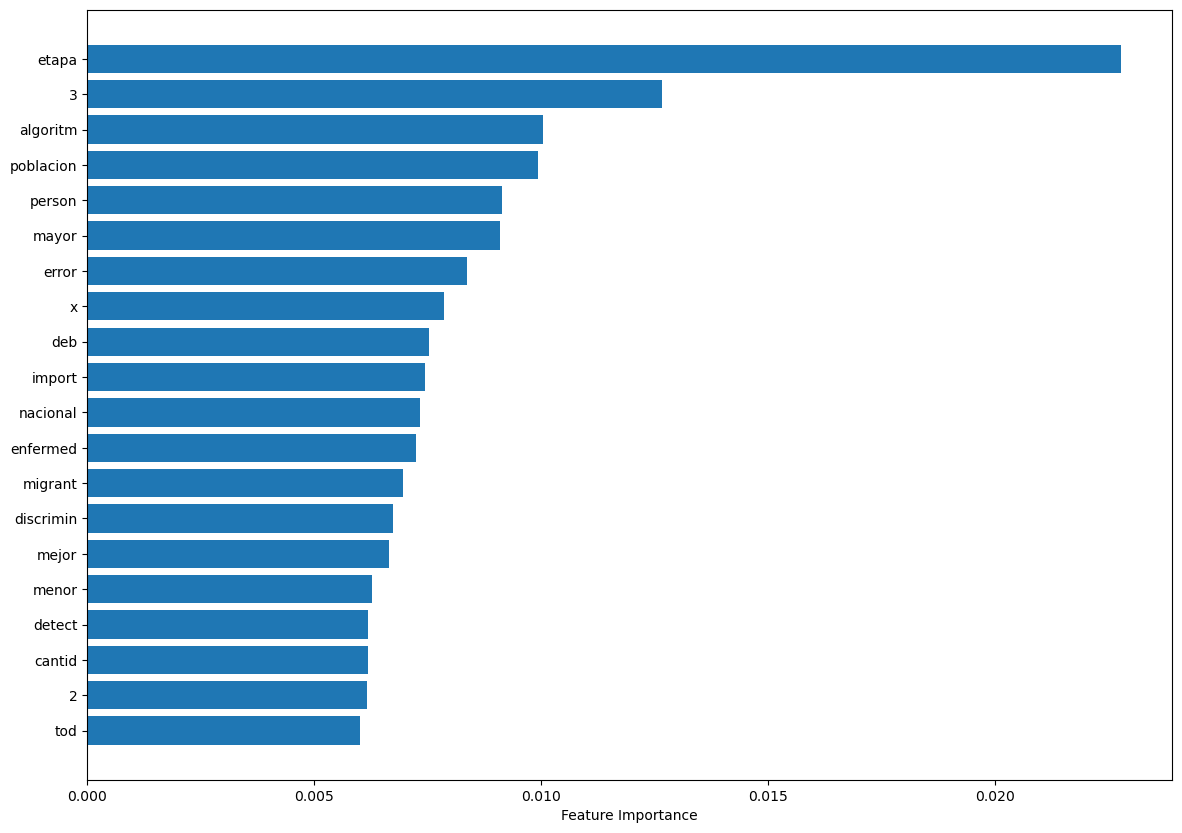

In [40]:
feature_importances = model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]

top_50_features = [feature_names[i] for i in sorted_idx[:20]][::-1]
top_50_importances = feature_importances[sorted_idx][:20][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_50_importances)), top_50_importances)
plt.yticks(range(len(top_50_importances)), top_50_features)
plt.xlabel('Feature Importance')
plt.show()

# Modelo 1 
Dada las selecciones en la etapa individual 1 y grupal, y las justificaciones en las tres etapas, predecir la selección en la etapa individual 2.

## Preprocesamiento

In [46]:
categorical_columns = ['gender', 'sel_Ind1', 'sel_Grup','sel_Ind2']
genders = [df.gender.unique().tolist()]

categorical_preprocessing = ColumnTransformer(
    transformers=[
        ('gender', Pipeline([
            ('extract', ColumnExtractor(columns=['gender'])),
            ('onehot_encoder', OneHotEncoder(sparse=False, categories=genders))
        ]), ['gender']),
        ('sel_etapa', Pipeline([
            ('extract', ColumnExtractor(columns=['sel_Ind1', 'sel_Grup','sel_Ind2'])),
            ('ordinal_encoder', OrdinalEncoder())
        ]), ['sel_Ind1', 'sel_Grup','sel_Ind2'])
    ],
    remainder='drop'
)

categorical_pipeline = Pipeline([
    ('categorical_preprocessing', categorical_preprocessing)
])

categorical_transformed_data = categorical_pipeline.fit_transform(dataset)

gender_column_names = [f'gender:{category}' for category in genders[0]]
categorical_transformed_df = pd.DataFrame(categorical_transformed_data, columns=gender_column_names + ['sel_Ind1', 'sel_Grup','sel_Ind2'])
categorical_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,sel_Ind2
0,0.0,1.0,0.0,0.0,2.0,0.0
1,0.0,1.0,0.0,2.0,1.0,1.0
2,0.0,1.0,0.0,3.0,2.0,2.0
3,0.0,1.0,0.0,2.0,1.0,3.0
4,0.0,1.0,0.0,2.0,2.0,2.0
...,...,...,...,...,...,...
406,0.0,1.0,0.0,0.0,0.0,0.0
407,0.0,1.0,0.0,0.0,2.0,2.0
408,1.0,0.0,0.0,2.0,2.0,2.0
409,0.0,1.0,0.0,2.0,2.0,2.0


In [51]:
text_columns = ['comment_Ind1', 'comment_Grup','comment_Ind2']

dataset['combined_text'] = dataset[text_columns].apply(lambda row: ' '.join(row), axis=1)

bog = CountVectorizer(
    tokenizer= StemmerTokenizer(),
    ngram_range=(1,1)
)

text_preprocessing = ColumnTransformer(
    transformers=[
        ('bag-of-words_combined', bog, 'combined_text')
    ],
    remainder='drop'
)

text_pipeline = Pipeline(
    [
        ("text_preprocessing", text_preprocessing)
    ]
)

text_transformed_data = text_pipeline.fit_transform(dataset).toarray()

feature_names_combined = text_pipeline.named_steps['text_preprocessing'].named_transformers_['bag-of-words_combined'].get_feature_names_out()
text_transformed_df = pd.DataFrame(text_transformed_data, columns=feature_names_combined)
dataset.drop('combined_text', axis=1, inplace=True)
text_transformed_df

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,0si,1,10,100,15,155,18,1pes,2,2ademas,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
407,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
data = pd.concat([categorical_transformed_df, text_transformed_df], axis=1)
data[['sel_Ind1', 'sel_Grup','sel_Ind2']] = data[['sel_Ind1', 'sel_Grup','sel_Ind2']].astype('category')
data

,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,sel_Ind2,0si,1,10,100,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
0,0.0,1.0,0.0,0.0,2.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1.0,0.0,2.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,0.0,3.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1.0,0.0,2.0,1.0,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1.0,0.0,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
407,0.0,1.0,0.0,0.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
408,1.0,0.0,0.0,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409,0.0,1.0,0.0,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df_train, df_test, y_train, y_test = train_test_split(data, data['sel_Ind2'], test_size=.3, stratify=data['sel_Ind2'])
df_train, df_test = df_train.drop(columns=['sel_Ind2']), df_test.drop(columns=['sel_Ind2'])

In [54]:
df_train

,gender:F,gender:M,gender:O,sel_Ind1,sel_Grup,0si,1,10,100,15,...,xenofob,xenofobi,xenofobiasin,xprefier,yaqu,yei,z,zenofobi,zon,ṕerson
195,1.0,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
193,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,1.0,0.0,0.0,2.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
410,1.0,0.0,0.0,3.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,0.0,1.0,0.0,2.0,2.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
215,0.0,1.0,0.0,4.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0.0,1.0,0.0,1.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114,0.0,1.0,0.0,3.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Entrenamiento

In [55]:
model = RandomForestClassifier(random_state=42)
model.fit(df_train, y_train)

print(classification_report(y_test, model.predict(df_test)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       0.56      0.83      0.67        46
         2.0       0.47      0.68      0.56        37
         3.0       0.67      0.12      0.20        17
         4.0       0.00      0.00      0.00         8
         5.0       0.00      0.00      0.00         3

    accuracy                           0.52       124
   macro avg       0.28      0.27      0.24       124
weighted avg       0.44      0.52      0.44       124



C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


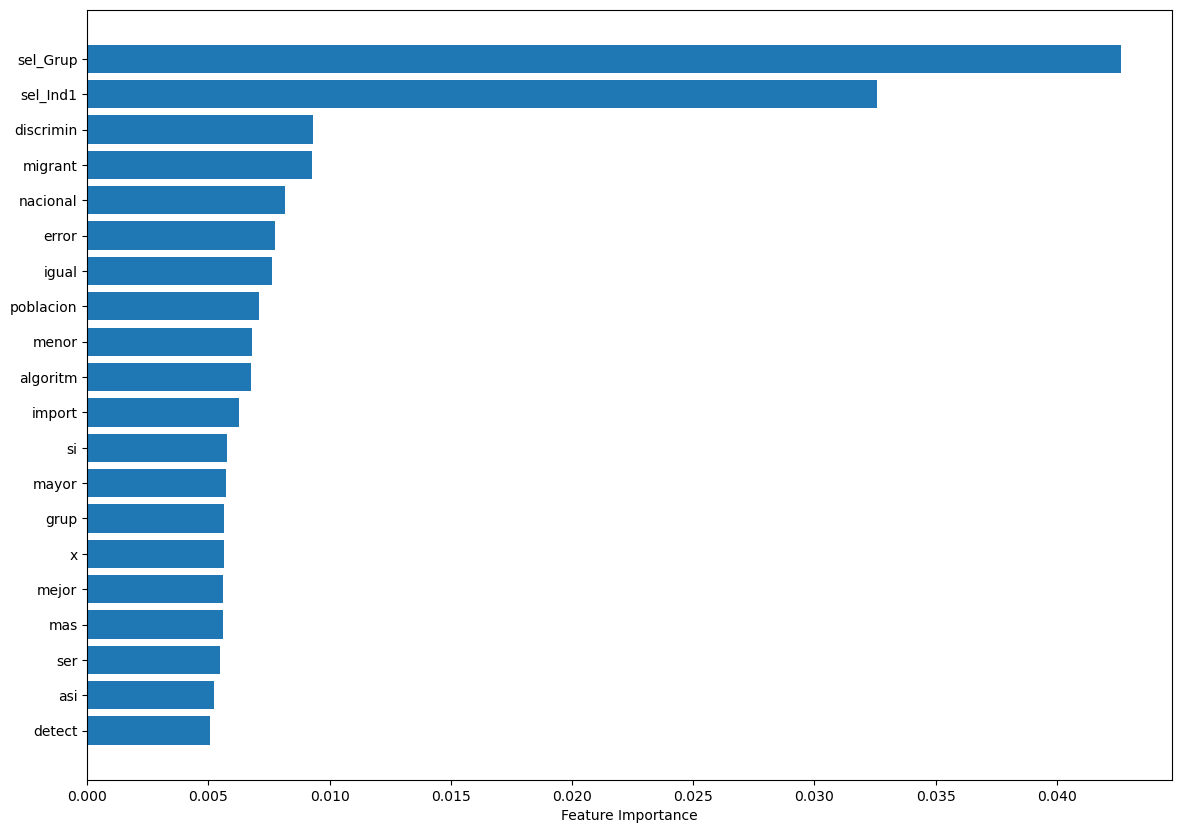

In [56]:
feature_importances = model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]

top_50_features = [feature_names[i] for i in sorted_idx[:20]][::-1]
top_50_importances = feature_importances[sorted_idx][:20][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_50_importances)), top_50_importances)
plt.yticks(range(len(top_50_importances)), top_50_features)
plt.xlabel('Feature Importance')
plt.show()

### Análisis de hiperparámetros

In [61]:
param_grid = {
    'n_estimators': [100, 200, 300],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(df_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(df_train, y_train)
y_pred = best_model.predict(df_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.5080645161290323


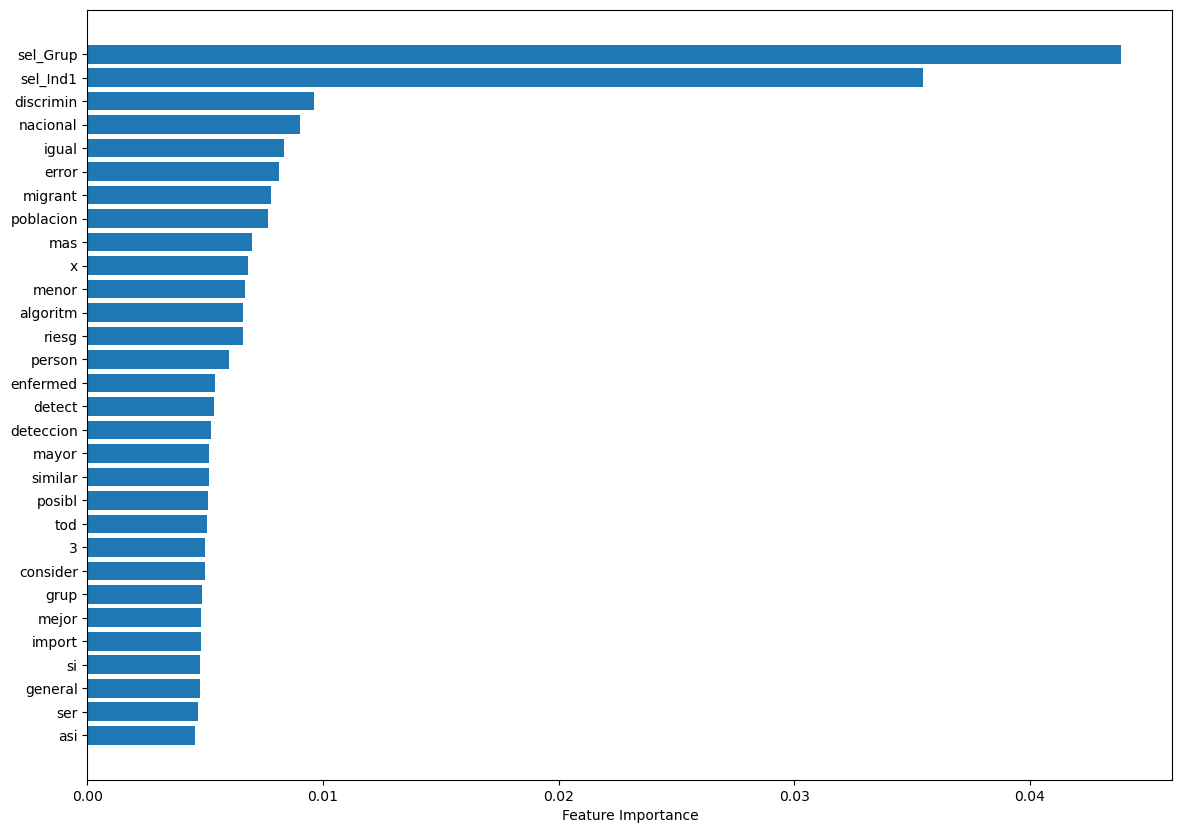

In [62]:
feature_importances = best_model.feature_importances_
feature_names = df_train.columns

sorted_idx = feature_importances.argsort()[::-1]
top_number = 30

top_features = [feature_names[i] for i in sorted_idx[:top_number]][::-1]
top_importances = feature_importances[sorted_idx][:top_number][::-1]

plt.figure(figsize=(14, 10))
plt.barh(range(len(top_importances)), top_importances)
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Feature Importance')
plt.show()

# Modelo de Ferret

In [63]:
dataset = pd.read_csv(f'dataset_{caso}_{diferencial}.csv')
dataset

,gender,sel_Ind1,sel_Grup,sel_Ind2,comment_Ind1,comment_Grup,comment_Ind2,summary
0,M,1,3,1,algoritmo x parece mejor elegir población dent...,perjudicar nadie elegimos 3 cosa algoritmo x a...,opción cambio etapa 3 puesto todavía pienso pr...,alo hola hola holaa q procede
1,M,3,2,2,extranjeros normalmente jóvenes población asen...,creemos debería ser 2 pues acuerdo debería ser...,aunque preferible población migrante joven pro...,wenas holis 2
2,M,4,3,3,pienso cualquier servicio especialmente relaci...,inicialmente habia optado poner 4 ahora cambio...,caso postura cambio tomando cuenta algoritmo x...,ola hola aloo saludos cordiales compañeros 4
3,M,3,2,4,parecer aunque algoritmo x potencialmente gene...,parecer aunque algoritmo x potencialmente gene...,finalmente tomando discusión anterior postura ...,holaa holaa holaa hola
4,M,3,3,3,deberia escoger levemente algoritmo x algoritm...,grupo analizaron distintas opiniones llego con...,mantengo firmemente postura mejor opcion elegi...,holaa holaa holaaa wenaaa hola
...,...,...,...,...,...,...,...,...
406,M,1,1,1,puede implementar método alternativo detección...,puede implementar método alternativo detección...,puede implementar método alternativo detección...,buenas gent3 1 x2 x3
407,M,1,3,3,algoritmo diseñado pais significa mayoria pers...,logaritmo va dirigido empresa publica pais pub...,cambie posicion argumento compañero buen porce...,q chat hola puse dos 1
408,F,3,3,3,opinión podrían utilizar ambos usar mayor exac...,considero debería escoger algoritmo x importan...,discusión anterior acuerdo preferible usar alg...,ª creo deberíamos elegir algoritmo x w olas
409,M,3,3,3,mantengo respuesta anterior creo seria injusto...,decidimos inclinarnos punto medio ambos algori...,percepción comienzo misma luego debate compañe...,buenas buenas lel parecer primera pondria punt...


In [ ]:
# Función para pasar las selecciones a tokens
def replace_sel_with_tokens(value):
    return f"seleccion {value}"

# Concatenamos el input
dataset['input'] = (
    dataset['sel_Ind1'].apply(replace_sel_with_tokens) +
    '</s>' +
    dataset['sel_Grup'].apply(replace_sel_with_tokens) +
    '</s>' +
    dataset['comment_Ind1'] +
    '</s>' +
    dataset['comment_Grup'] +
    '</s>' +
    dataset['comment_Ind2'] +
    '</s>' +
    dataset['summary']
)

# Generamos los labels
dataset['labels'] = np.sign(dataset['sel_Ind2'] - dataset['sel_Ind1'])

# Pasamos al rango (0,1,2)
# 0 hubo cambio hacia abajo, es decir, sel_Ind1 > sel_Ind2
# 1 no hubo cambio
# 2 hubo cambio hacia arriba, es decir, sel_Ind1 < sel_Ind2
dataset['pytorch_labels'] = dataset['labels'] + 1

input_dataframe = dataset[['input', 'pytorch_labels']]
input_dataframe

### Fine-tuning para clasificar cambio de postura

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from ferret import Benchmark
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split

# Cargamos el modelo a fine-tunear
name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(name)
tokenizer = AutoTokenizer.from_pretrained(name)

In [ ]:
# Obtenemos la cantidad de tokens por input y graficamos
seq_lengths = [len(tokenizer.encode(text, padding=True, truncation=True, max_length=1024)) for text in input_dataframe['input']]
plt.hist(seq_lengths)
plt.show()

In [ ]:
# Separamos feature y label
X, y = input_dataframe['input'], input_dataframe['pytorch_labels']

# Separamos en train (70%), val (20%) y test (10%)
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.33, random_state=42)

# Tokenizamos
max_length = max(seq_lengths)
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
X_val_tokenized = tokenizer(list(X_val), padding=True, truncation=True, return_tensors="pt", max_length=max_length)
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt", max_length=max_length)

# Pasamos a tensores
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Generamos DataSet
train_dataset = TensorDataset(X_train_tokenized['input_ids'].squeeze(), X_train_tokenized['attention_mask'].squeeze(), y_train_tensor)
val_dataset = TensorDataset(X_val_tokenized['input_ids'].squeeze(),  X_val_tokenized['attention_mask'].squeeze(), y_val_tensor)
test_dataset = TensorDataset(X_test_tokenized['input_ids'].squeeze(), X_test_tokenized['attention_mask'].squeeze(), y_test_tensor)

# Generamos DataLoader
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

# Definimos optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

# Definimos scheduler
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Pasamos a device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
from tqdm import tqdm

# Entrenamos
epochs = 3
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)

    # Validamos
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation", leave=False):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_val_loss}")

In [ ]:
# Guardamos el modelo finetuneado
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")

### Benchmark de Ferret

In [ ]:
# Cargamos el modelo de clasificación
loaded_model = AutoModelForSequenceClassification.from_pretrained('/content/fine_tuned_model')
loaded_tokenizer = AutoTokenizer.from_pretrained('/content/fine_tuned_model')

In [ ]:
# Evaluación del modelo
model.eval()

correct_predictions = 0
total_samples = 0

for batch in tqdm(test_dataloader, desc="Test", leave=False):
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
    with torch.no_grad():
        outputs = loaded_model(input_ids, attention_mask=attention_mask)

    predicted_class = torch.argmax(outputs.logits, dim=-1).item()
    ground_truth = labels.item()

    correct_predictions += int(predicted_class == ground_truth)
    total_samples += 1

accuracy = correct_predictions / total_samples

print(f"Accuracy on the test dataset: {accuracy:.2%}")

In [ ]:
# Ejemplo
bench = Benchmark(model, tokenizer)
explanations = bench.explain('You look stunning!')
bench.show_table(explanations)

In [ ]:
evaluations = bench.evaluate_explanations(explanations, target=1)
bench.show_evaluation_table(evaluations)